In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

ROOT = Path('../')
sys.path.append(str(ROOT))
import came
from came import pipeline, pp, pl

Using backend: pytorch


## 0 Load data (`scanpy.AnnData` object)

In [7]:
example_data_dict = came.load_example_data()
print(example_data_dict.keys())

dsnames = ('Baron_human', 'Baron_mouse')
dsn1, dsn2 = dsnames

adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']

key_class1 = key_class2 = example_data_dict['key_class']

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])
a new directory made:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs


In [ ]:
# ========= customize paths ==========

tiss, (sp1, sp2) = 'brain', ('human', 'mouse')
dsnames = ('Lake_2018', 'Tasic18')
dsn1, dsn2 = dsnames

dir_gmap = Path('E:/lxy_pro/004/resources/mart_exports/exported_gene_matches')
datadir = Path('E:/lxy_pro/004/datasets') / 'formal' / tiss

df_varmap_1v1 = pd.read_csv(dir_gmap / f'gene_matches_1v1_{sp1}2{sp2}.csv', )
df_varmap = pd.read_csv(dir_gmap / f'gene_matches_{sp1}2{sp2}.csv', )

dsn1, dsn2 = dsnames
adata_raw1 = sc.read_h5ad(datadir / f'raw-{dsn1}.h5ad')
adata_raw2 = sc.read_h5ad(datadir / f'raw-{dsn2}.h5ad')
adatas = [adata_raw1, adata_raw2]

key_class1 = 'cell_ontology_class'
key_class2 = 'cell_ontology_class'

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_case_res' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)

In [ ]:
# ====== subsampling and filtering genes (optional) =====
for _adt, _name in zip([adata_raw1, adata_raw2], dsnames):
    if _adt.shape[0] >= 2e4:
        print(f'Doing subsampling for {_name}')
        sc.pp.subsample(_adt, fraction=0.5)

sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)

In [ ]:
# Inspect classes
pd.concat([
    pd.value_counts(adata_raw1.obs[key_class1]),
    pd.value_counts(adata_raw2.obs[key_class2]),
], axis=1)

## 1 Run default pipeline of CAME

Parameter setting:

In [ ]:
# the numer of training epochs
n_epochs = 350

# the training batch size (when GPU memory is limited, recommanded is 8192 or more)
batch_size = None  

# the number of epochs to skip for checkpoint backup
n_pass = 100

# whether to use the single-cell network
use_scnets = True

In [8]:
came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=use_scnets,
)

dpair, trainer, h_dict, predictor, ENV_VARs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=n_pass,
    batch_size=batch_size,
    plot_results=True,
)

obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes

[leiden] Time used:  0.2417 s
groups to be removed:
	 []
650 genes before taking unique
taking total of 523 unique differential expressed genes
groups to be removed:
	 []
400 genes before taking unique
taking total of 345 unique differential expressed genes
already exists:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs
already exists:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)
[*] Setting dataset names:
	0-->Baron_human
	1-->Baron_mouse
[*] Setting aligned features for observation nodes (self._features)
[*] Setting un-aligned features (`self._ov_adjs`) for making links connecting observation and variable nodes
[*] Setting adjacent matrix connecting variables from these 2 datasets (`self._vv_adj`)
Index(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name',
       'donor', 'library', 'organ', 'organism', 'platform'],
      dtype='object')
Index(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name',
       'donor', 'lib

figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/cluster_index.png
states loaded from: ../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/_models/weights_epoch111.pt
type B pancreatic cell      1517
pancreatic ductal cell       565
pancreatic A cell            768
pancreatic acinar cell       231
pancreatic PP cell           108
pancreatic D cell            362
pancreatic stellate cell     174
endothelial cell             201
macrophage                    54
mast cell                      8
Schwann cell                   8
T cell                        11
pancreatic epsilon cell        3
unknown                       18
dtype: int64
object saved into:
	 ../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/datapair_init.pickle
Re-order the rows
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/contingency_matrix(acc87.7%).png
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(

In [ ]:
# load_other_ckpt = False
# if load_other_ckpt:
#     obs, df_probs, h_dict, predictor = pipeline.gather_came_results(
#             dpair,
#             trainer,
#             classes=ENV_VARs['classes'],
#             keys=(key_class1, key_class2),
#             keys_compare=(key_class1, key_class2),
#             resdir=resdir,
#             checkpoint='last',
#             batch_size=None,
#     )

### Plot cell-typing results

figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/contingency_mat.png


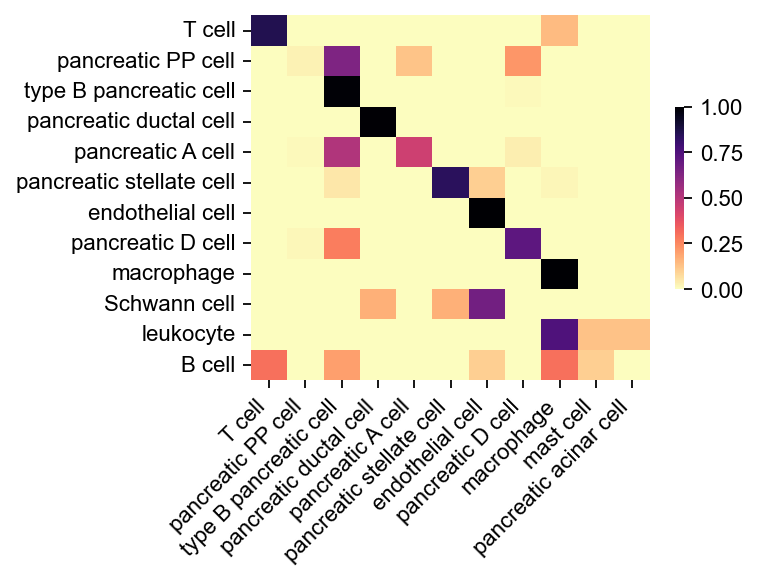

In [12]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values
ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/heatmap_probas.pdf


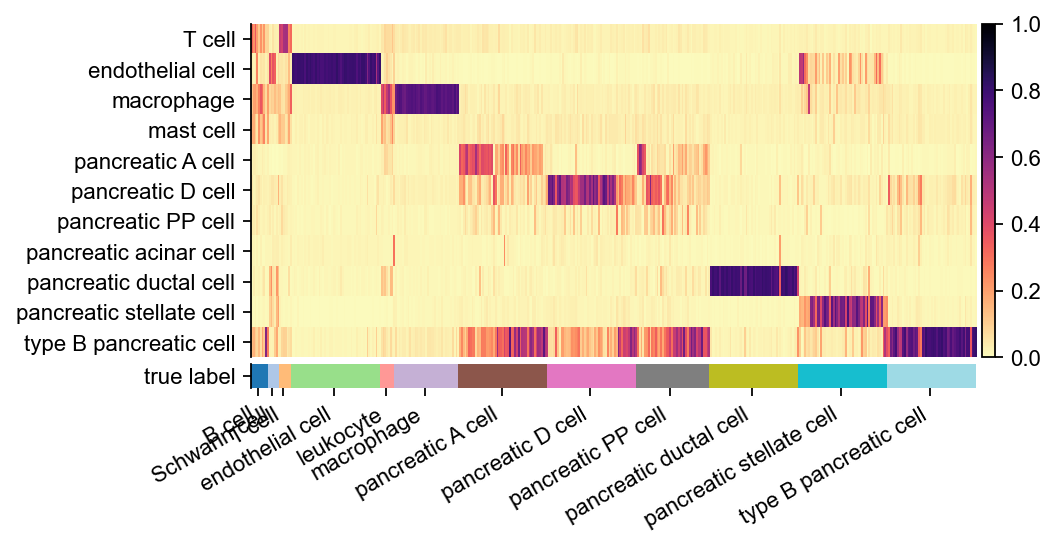

In [9]:
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]


gs = pl.wrapper_heatmap_scores(
        df_probs.iloc[obs_ids2], obs.iloc[obs_ids2], ignore_index=True,
        col_label='celltype', col_pred='predicted',
        n_subsample=50,
        cmap_heat='magma_r',  # if prob_func == 'softmax' else 'RdBu_r'
        fp=figdir / f'heatmap_probas.pdf'
    )

gs.figure

## 2 Further analysis

By default, CAME will use the **last** layer of hidden states, as the embeddings, to produce cell- and gene-UMAP. 

> You can also load ALL of the model hidden states that have been seved during CAME's default pipeline:

```py
hidden_list = came.load_hidden_states(resdir / 'hidden_list.h5')
hidden_list  # a list of dicts
h_dict = hidden_list[-1]. # the last layer of hidden states
```

Make AnnData objects, storing only the CAME-embeddings and annotations, for cells and genes.

In [14]:
adt = pp.make_adata(h_dict['cell'], obs=dpair.obs, assparse=False, ignore_index=True)
gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)

# adt.write(resdir / 'adt_hidden_cell.h5ad')
# gadt.write_h5ad(resdir / 'adt_hidden_gene.h5ad')

adding columns to `adata.obs` (ignore_index=True):
original_name, dataset, REF, celltype, predicted, max_probs, is_right, type B pancreatic cell, pancreatic ductal cell, pancreatic A cell, pancreatic acinar cell, pancreatic PP cell, pancreatic D cell, pancreatic stellate cell, endothelial cell, macrophage, mast cell, Schwann cell, T cell, pancreatic epsilon cell, done!
adding columns to `adata.obs` (ignore_index=True):
name, dataset, done!


### 2.1 UMAP of cell embeddings

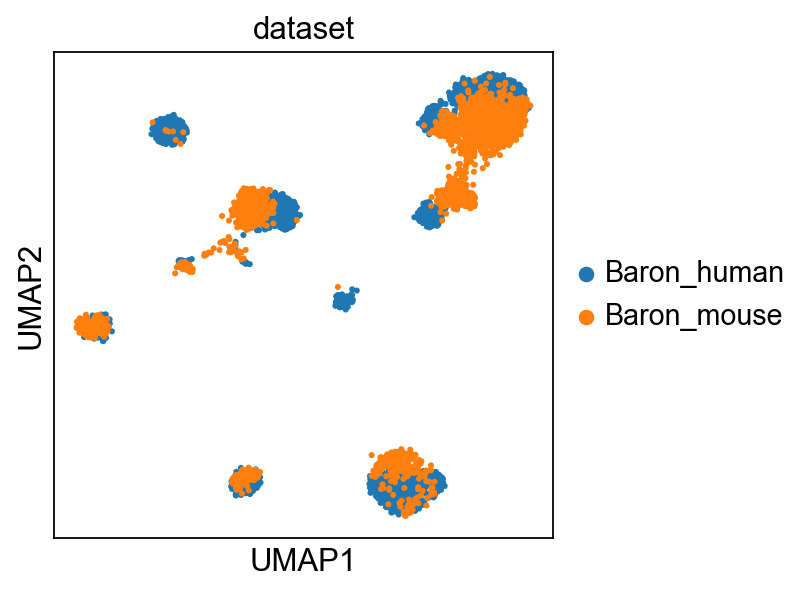

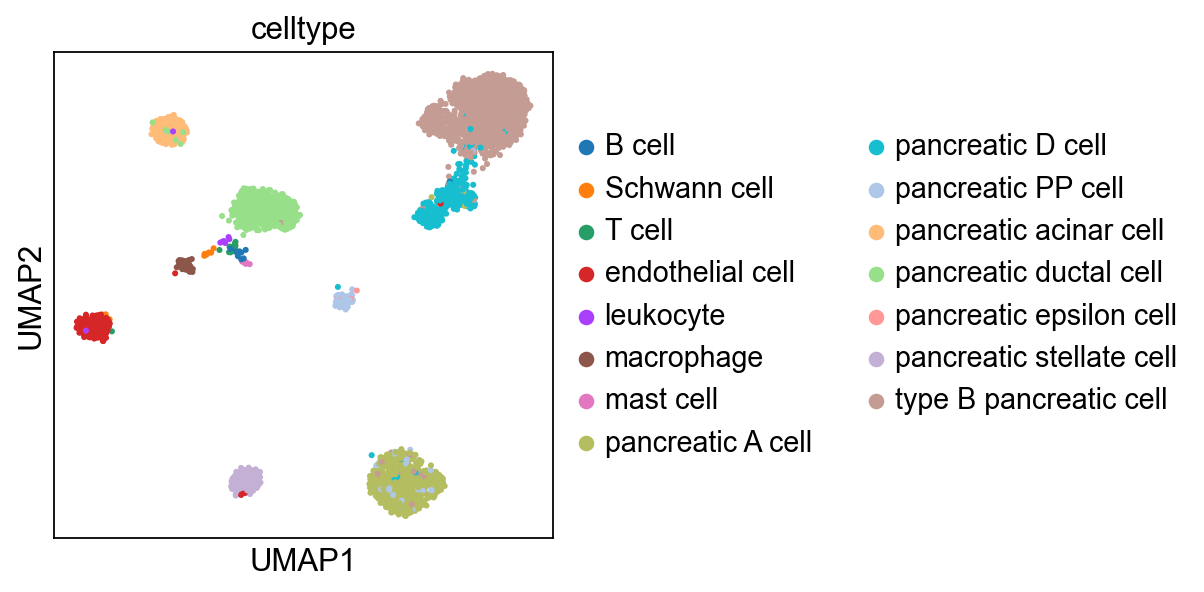

In [16]:
# from CAME_v0.utils.plot_pub import plot_pure_umap

sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)
# sc.pl.umap(adt, color=['dataset', 'celltype'], ncols=1)

ftype = ['.svg', ''][1]
sc.pl.umap(adt, color='dataset', save=f'-dataset{ftype}')
sc.pl.umap(adt, color='celltype', save=f'-ctype{ftype}')


In [17]:
# store UMAP coordinates
obs_umap = adt.obsm['X_umap']
obs['UMAP1'] = obs_umap[:, 0]
obs['UMAP2'] = obs_umap[:, 1]
obs.to_csv(resdir / 'obs.csv')
adt.write(resdir / 'adt_hidden_cell.h5ad')

In [ ]:
# setting UMAP to the original adata
adata1.obsm['X_umap'] = obs_umap[obs_ids1]
adata2.obsm['X_umap'] = obs_umap[obs_ids2]

### 2.2 UMAP of genes

/Users/yanyan/opt/anaconda3/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'name' as categorical
/Users/yanyan/opt/anaconda3/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical


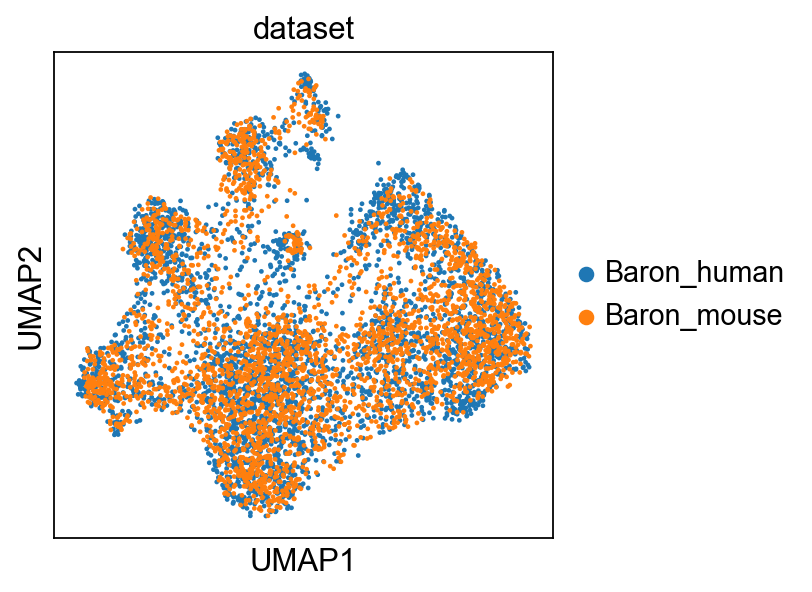

In [18]:
sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')

# gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)
sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset', )


In [64]:
# joint gene module extraction 
sc.tl.leiden(gadt, resolution=.8, key_added='module')
sc.pl.umap(gadt, color='module', ncols=1)

gadt.write(resdir / 'adt_hidden_gene.h5ad')

In [22]:
# link-weights between homologous gene pairs 
df_var_links = came.weight_linked_vars(
    gadt.X, dpair._vv_adj, names=dpair.get_vnode_names(),
    matric='cosine', index_names=dsnames,
)

/Users/yanyan/opt/anaconda3/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['USP2', 'ACLY', 'IL18R1', 'IFITM2', 'GRPEL2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/Users/yanyan/opt/anaconda3/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Edn2', 'Wdr1', 'Abcc9', 'C4b', 'Zfp605']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


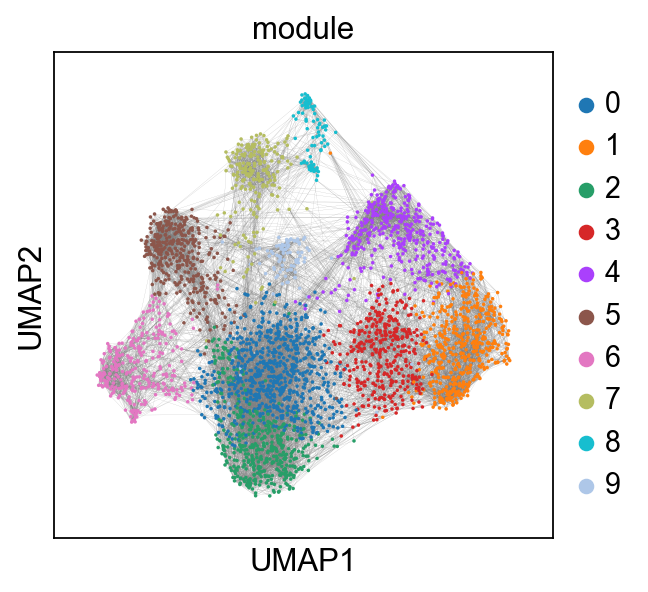

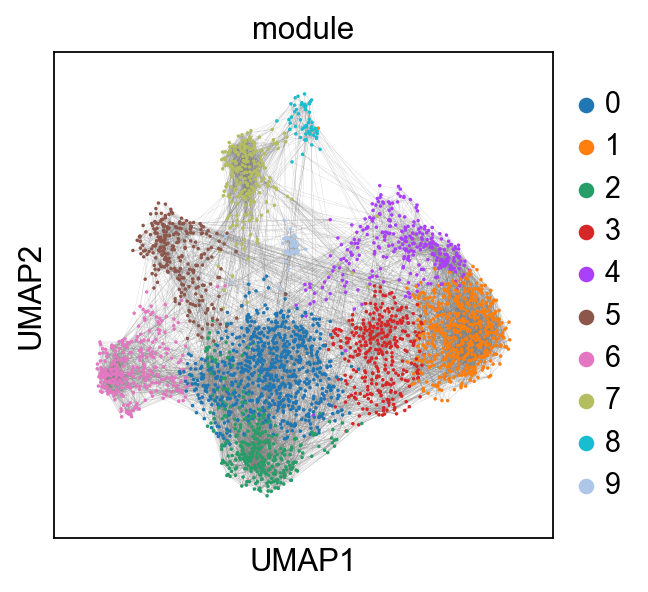

In [25]:
# gadt.obs_names = gadt.obs_names.astype(str)
gadt1, gadt2 = pp.bisplit_adata(gadt, 'dataset', dsnames[0], reset_index_by='name')

color_by = 'module'
sc.pl.umap(gadt1, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsnames[0]}')
sc.pl.umap(gadt2, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsnames[0]}')

### 2.3 Gene-expression-profiles (for each cell type) on gene UMAP

Compute average expressions for each cell type.

In [63]:
# averaged expressions
avg_expr1 = pp.group_mean_adata(
    adatas[0], groupby=key_class1,
    features=dpair.vnode_names1, use_raw=True)
avg_expr2 = pp.group_mean_adata(
    adatas[1], groupby=key_class2,
    features=dpair.vnode_names2, use_raw=True)

# z-scores across cell types
avg_expr_add1, avg_expr_add2 = list(map(
    lambda x: pp.zscore(x.T).T, (avg_expr1, avg_expr2)
))

# add annos
pp.add_obs_annos(gadt1, avg_expr_add1, ignore_index=True)
pp.add_obs_annos(gadt2, avg_expr_add2, ignore_index=True)

# gadt1.write(resdir / 'adt_hidden_gene1.h5ad')  # scanpy raise errors
# gadt2.write(resdir / 'adt_hidden_gene2.h5ad')



Computing averages grouped by cell_ontology_class
Calculating feature averages for 13 groups
['Schwann cell' 'T cell' 'endothelial cell' 'macrophage' 'mast cell'
 'pancreatic A cell' 'pancreatic D cell' 'pancreatic PP cell'
 'pancreatic acinar cell' 'pancreatic ductal cell'
 'pancreatic epsilon cell' 'pancreatic stellate cell'
 'type B pancreatic cell']
Computing averages grouped by cell_ontology_class
Calculating feature averages for 12 groups
['B cell' 'Schwann cell' 'T cell' 'endothelial cell' 'leukocyte'
 'macrophage' 'pancreatic A cell' 'pancreatic D cell' 'pancreatic PP cell'
 'pancreatic ductal cell' 'pancreatic stellate cell'
 'type B pancreatic cell']
adding columns to `adata.obs` (ignore_index=True):
NOTE that column "Schwann cell" will be covered by new values
Schwann cell, NOTE that column "T cell" will be covered by new values
T cell, NOTE that column "endothelial cell" will be covered by new values
endothelial cell, NOTE that column "macrophage" will be covered by new val

In [65]:
gadt1.write(resdir / 'adt_hidden_gene1.h5ad')  # scanpy raise errors
# gadt2.write(resdir / 'adt_hidden_gene2.h5ad')

ValueError: Unable to create dataset (name already exists)

Above error raised while writing key '__categories/name' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'name' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'obs' of <class 'h5py._hl.files.File'> from /.

plot cell type gene-profiles (plot all the cell types) on UMAP

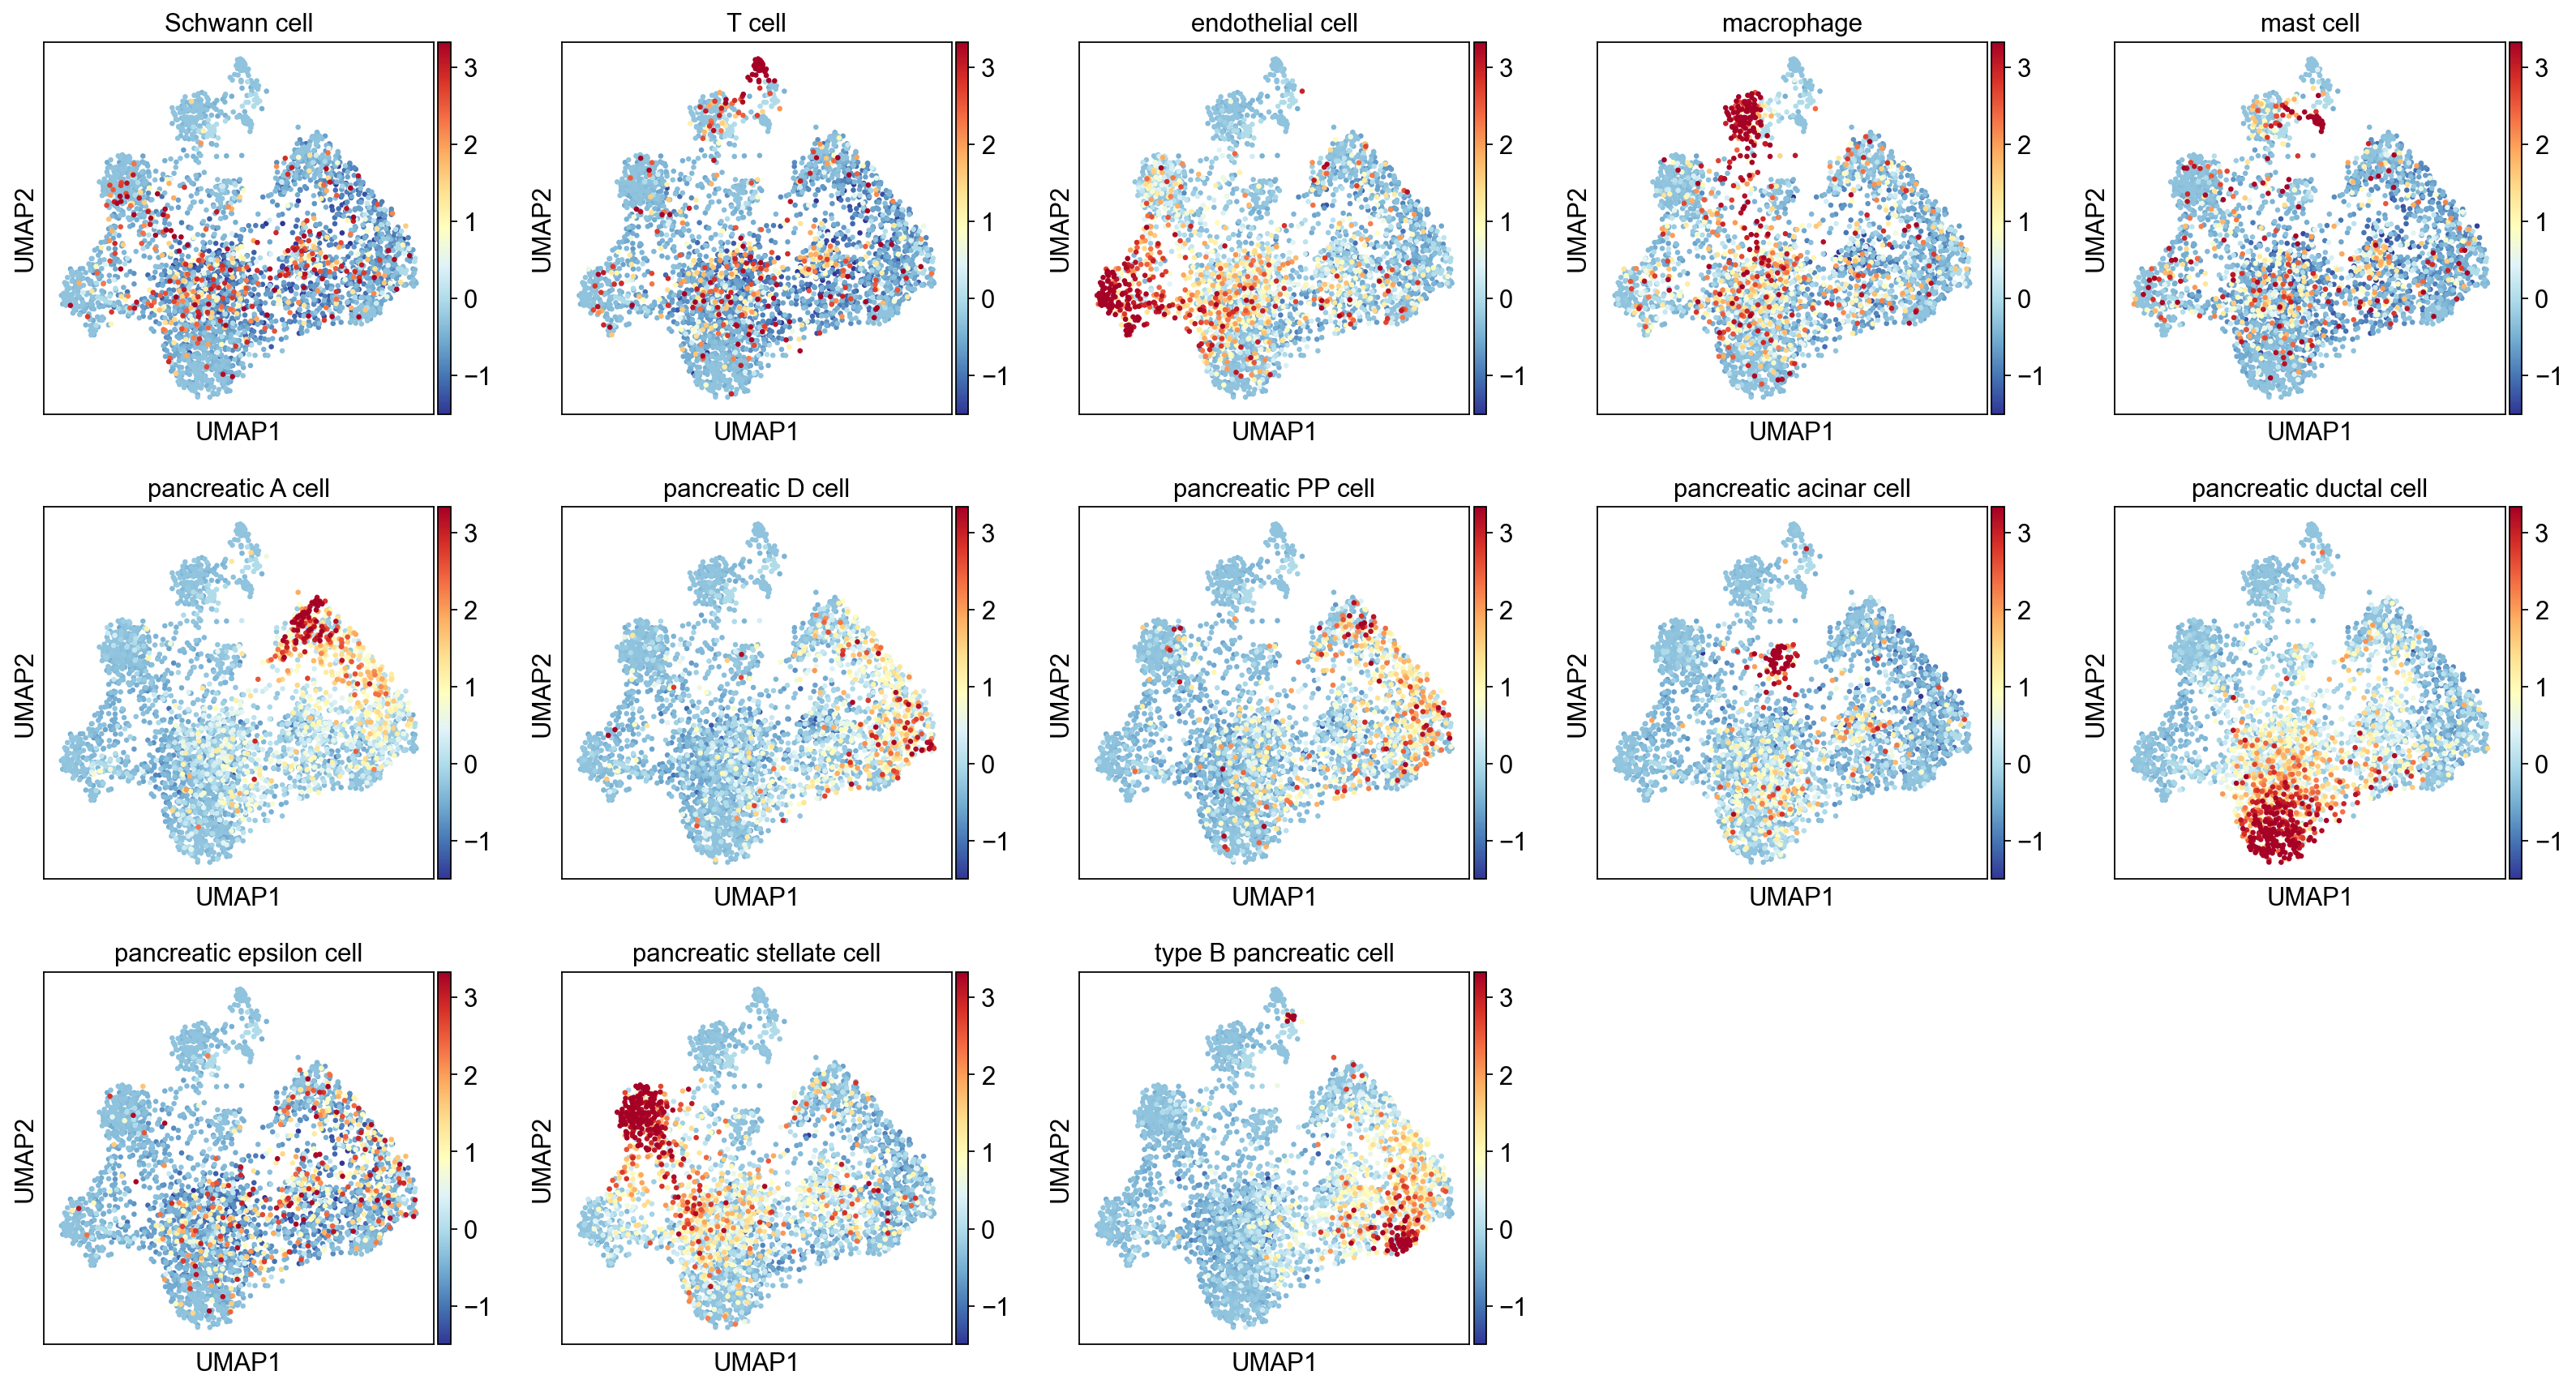

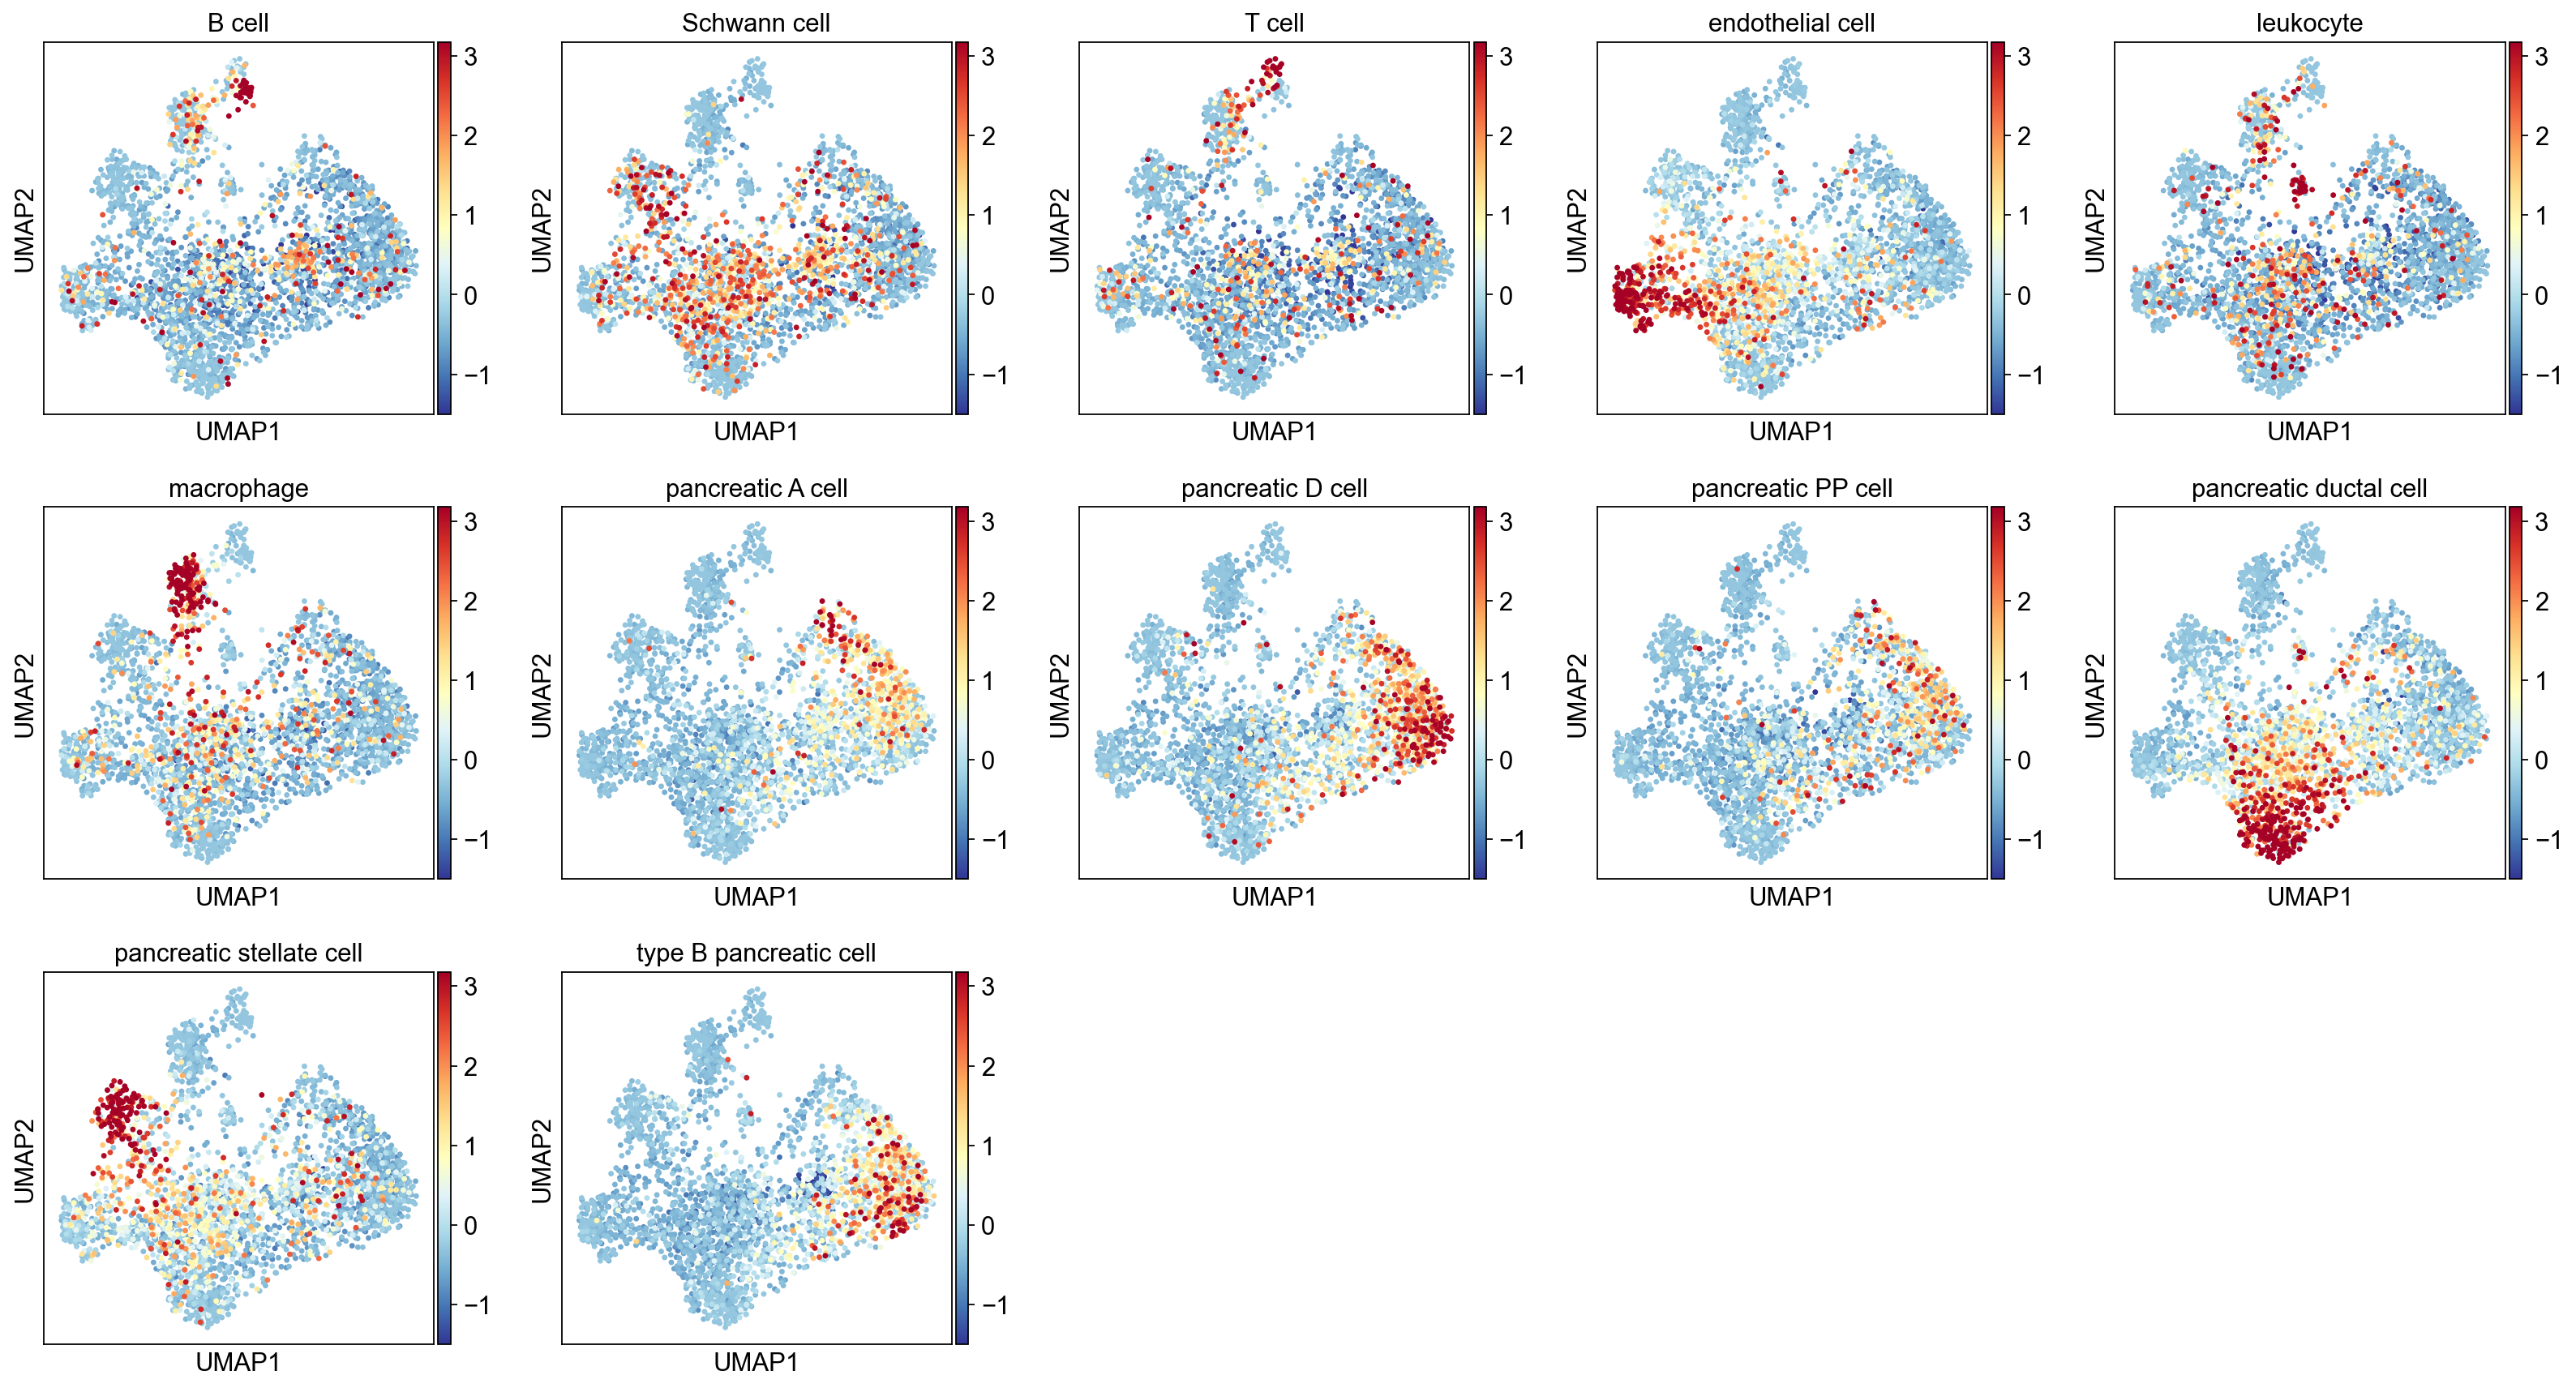

In [29]:
sc.set_figure_params(fontsize=14)

ctypes1 = avg_expr1.columns.tolist()
ctypes2 = avg_expr2.columns.tolist()
cmap_expr = 'RdYlBu_r'
vmax = None
vmin = - 1.5
plkwds = dict(color_map=cmap_expr, vmax=vmax, vmin=vmin, ncols=5, )

sc.pl.umap(gadt1, color=ctypes1,
           # edges=True, size=50,
           save=f'_exprAvgs-{dsn1}-all.png', **plkwds)
sc.pl.umap(gadt2, color=ctypes2,
           #           edges=True, size=50,
           save=f'_exprAvgs-{dsn2}-all.png', **plkwds)


Text(0.5, 1.0, 'Schwann cell')

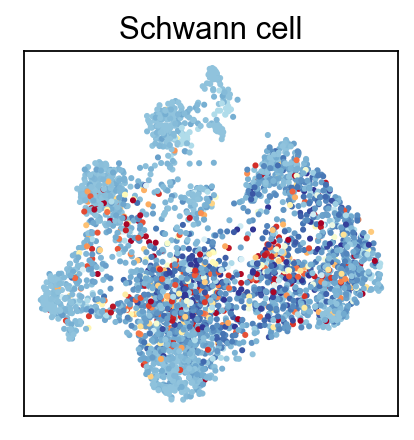

In [55]:
_ctype = ctypes1[0]
_xy = gadt1.obsm['X_umap'].T
_color_values = gadt1.obs[_ctype]

fig, ax = plt.subplots(1, 1, figsize=(3, 3), gridspec_kw={'wspace': 0.1})
ax.scatter(*_xy, s=3,
           c=_color_values, 
           cmap=cmap_expr, 
           vmin=-1.5, vmax=None
          )
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(_ctype)
# ax.set_frame_on(False)

### 2.4 Abstracted graph

In [60]:
norm_ov = ['max', 'zs', None][1]
cut_ov = 0.  # 5#(0.5, 2.5)
# norm_ov = 'zs'
# cut_ov = (0.5, 2.5)
ovby = ['expr', 'attn'][0]
groupby_var = 'module'
obs_labels1, obs_labels2 = adt.obs['celltype'][dpair.obs_ids1], \
                           adt.obs['celltype'][dpair.obs_ids2]
var_labels1, var_labels2 = gadt1.obs[groupby_var], gadt2.obs[groupby_var]

sp1, sp2 = 'human', 'mouse'
g = came.make_abstracted_graph(
    obs_labels1, obs_labels2,
    var_labels1, var_labels2,
    avg_expr1, avg_expr2,
    df_var_links,
    tags_obs=(f'{sp1} ', f'{sp2} '),
    tags_var=(f'{sp1} module ', f'{sp2} module '),
    cut_ov=cut_ov,
    norm_mtd_ov=norm_ov,
)


3422 3136
---> ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Edges with weights lower than 0 were cut out.
Edges with weights lower than 0 were cut out.
---> avg_vo1
                  Schwann cell    T cell  endothelial cell  macrophage  \
__temp_labels__                                                         
0                   -0.277830 -0.237947          0.499336    0.320177   
1                   -0.355043 -0.409034         -0.196822   -0.229939   
2                   -0.282662 -0.268979          0.076649   -0.047368   
3                   -0.090612 -0.258636          0.118255   -0.186651   
4                   -0.430247 -0.400228         -0.213996   -0.094592   
5                    0.038466 -0.257904          0.198593   -0.078111   
6                   -0.178036 -0.123953          2.267948    0.079258   
7                   -0.293021  0.213441         -0.222264    2.267433   
8                   -0.257752  1.404918         -0.208215   -0.235043   
9                   -0.16

[13, 10, 10, 12]
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/abstracted_graph-module-cut0.0-zs-expr.pdf


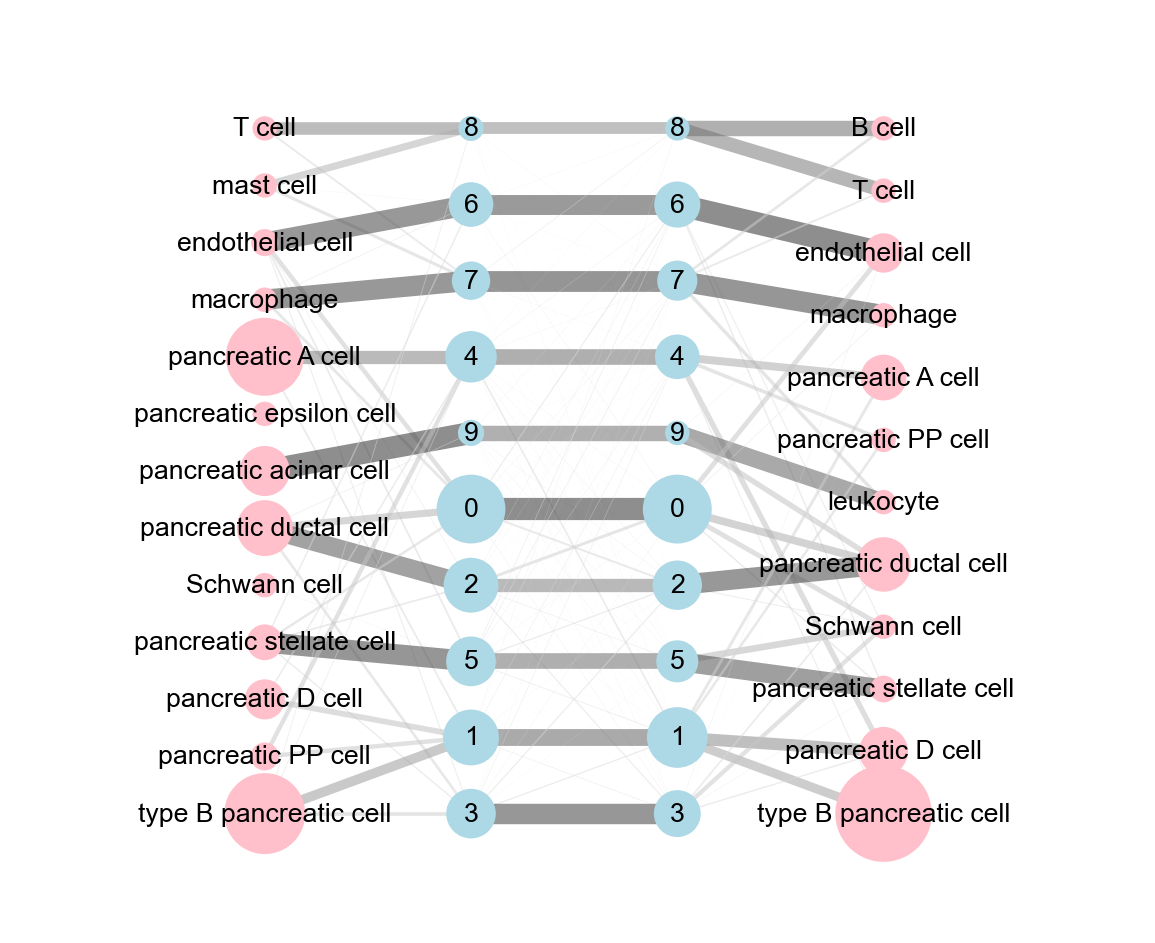

In [61]:
''' visualization '''
fp_abs = figdir / f'abstracted_graph-{groupby_var}-cut{cut_ov}-{norm_ov}-{ovby}.pdf'
ax = pl.plot_multipartite_graph(
    g, edge_scale=10,
    figsize=(9, 7.5), alpha=0.5, fp=fp_abs)  # nodelist=nodelist,

ax.figure

[13, 10, 10, 12]
figure has been saved into:
	../_temp/('Baron_human', 'Baron_mouse')-(09-04 10.52.20)/figs/abstracted_graph-nolabels.pdf


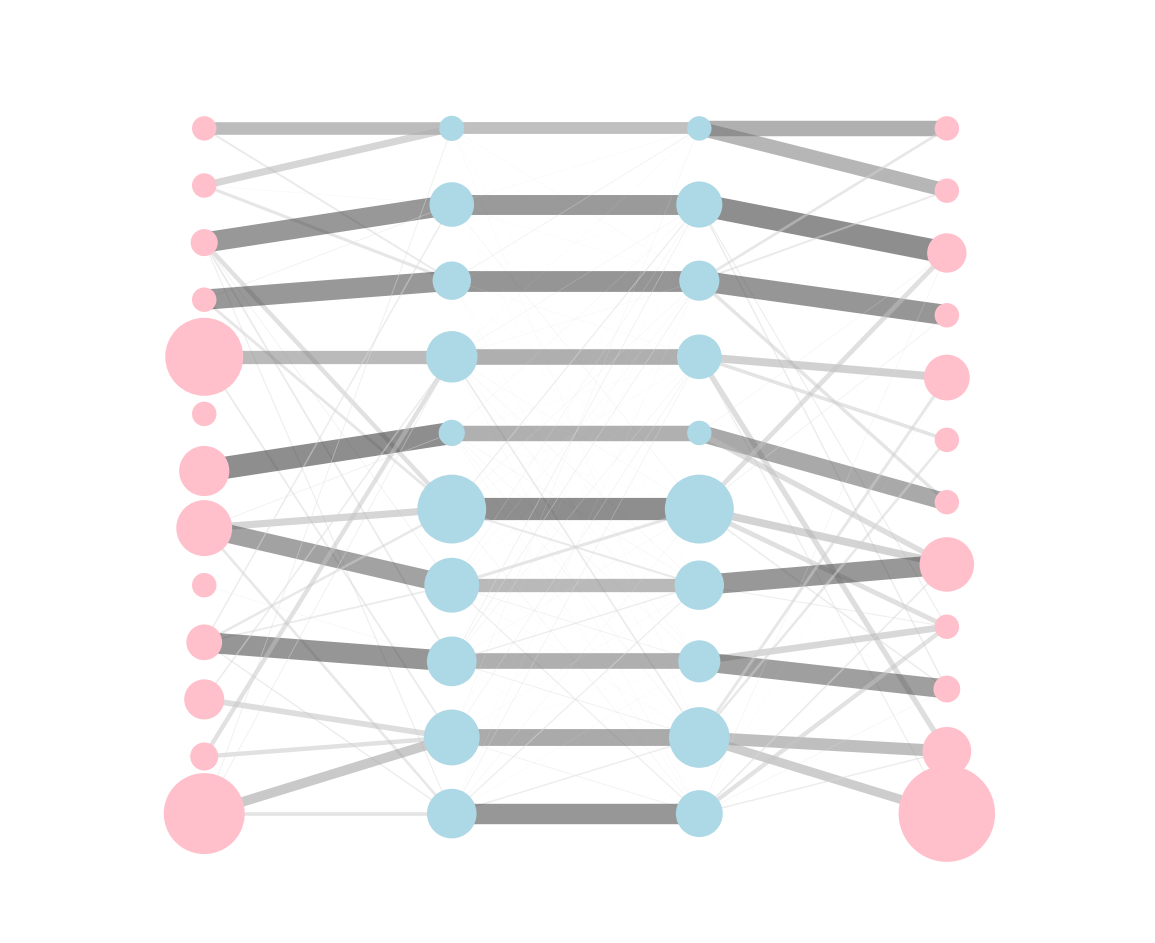

In [59]:
# unlabeled
ax = pl.plot_multipartite_graph(
    g, edge_scale=10, figsize=(9, 7.5), alpha=0.5,
    xscale=1.25,
    fp=figdir / f'abstracted_graph-nolabels.pdf',
    with_labels=False)  # nodelist=nodelist,

ax.figure